# To-do for future kian
- more code tests for simulation
- object oriented with classes
    - having $\Delta t, \Delta x, N_{part}, v_{th}, v_0, n_{species}, T_f$ as parameters (ran out of time)
- fast fourier transform instead of discrete
- 2D?

# Electrostatic Particle in Cell

In [1]:
import numpy as np
from pic_funcs import * # i hate using * but oh well
from scipy.stats import maxwell
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation
from IPython.display import HTML
import h5py
import os
plt.style.use("ggplot")

### General steps

1. get initial velocity
1. get initial weights with random $r_i$
1. get initial $\phi$
1. get initial electric field
1. get acceleration from electric field
1. In loop
    - update $r_i$
    - update weights
    - solve for $\phi$ array
    - update $E_j$s
    - update $E_i$
    - update velocity

### PIC Steps/Details

For a time-independent system, the maxwell equations are

$$
\nabla \cdot E = \rho, \quad \nabla \cdot B = 0
\\
\nabla \times E = 0, \quad \nabla \times B = 0
$$

so ultimately by combining the $E$ equations,
$$
\nabla ^2 \phi = \rho
$$

where $\phi$ is the potential and $\rho$ is the density.

We ultimately want to find the acceleration
$$
F = ma = -qE
\implies a = -\frac{q}{m}E
$$

as that is what pushes the particles. And from acceleration, we use the leap-frog method to the velocity and position of a particle, such that

$$
v = \frac{\Delta t a}{2} \qquad r = \Delta t v.
$$


But first, $E$ is

$$
E = \frac{\text{d}\phi}{\text{d}x}
$$

and $\phi$ is found through Poisson's Equation.

To find $\phi$, we first need to calculate $\rho$ and we can do that by defining it as a ratio between how close the particle is to one coordinate and the total $\Delta x$ between two coordinates of a bin -- a particle mesh. A 1D particle mesh looks like a line with bins. Each bin is described by two $x$ coordinates, $x_j$ and $x_{j+1}$, and within that bin is a particle $i$ with location $r_i$. The size of the bin is $\Delta x = L / N$, where $L$ is the length of the system and $N$ is the number of cells. So one can find the density with the ratios

$$
\rho_j = \sum_{i=0}^{N_p}\frac{x_{j+1} - r_i}{\Delta x}, \quad \rho_{j+1}=\sum_{i=0}^{N_p}\frac{r_i - x_{j}}{\Delta x},
$$

where $N_p$ is the number of particles within a bin.
These densities make sense because if a particle is closer to the right side of the bin, then the left side will have less density as the ratio increases.

And then Poisson's equation in 1D tells us that


\begin{equation}
\tag{1}
\frac{\text{d}^2\phi}{\text{d}x^2} = \rho,
\end{equation}

which can be approximated using the finite difference method. For the first derivative of a general function $f$, the finite difference method yields

$$
f'(a) = \frac{f(a+h)-f(a)}{h},
$$

and then it follows that the second derivative is

$$
f''(a) = \frac{f(a) - 2f(a+h) + f(a+2h)}{h^2}.
$$

If we apply this function to our $\phi$, we can define $f(a+h)$ as $\phi_j$, so then from equation $1$,

$$
\frac{\text{d}^2\phi}{\text{d}x^2} = \frac{\phi_{j-1} - 2\phi_j + \phi_{j+1}}{\Delta x^2}=\rho.
$$

This finite difference is represented in the matrix form as

$$
\frac{1}{(\Delta x)^2}
\begin{pmatrix}
-2 & 1 & 0 & \dots & 0 & 1 \\
1 & -2 & 1 &  & & 0\\
0 & 1 & -2 &  &  &  \vdots\\
\vdots  &   & &  \ddots & & 0\\
0 &  & & 1 & -2 & 1\\
1 & 0 & \dots& 0 & 1 & -2
\end{pmatrix}
\begin{pmatrix}
\phi_1 \\
\phi_2 \\
\phi_3 \\
\vdots \\
\phi_{m - 1} \\
\phi_m \\
\end{pmatrix}
=
\begin{pmatrix}
\rho_1 \\
\rho_2 \\
\rho_3 \\
\vdots \\
\rho_{m - 1} \\
\rho_m \\
\end{pmatrix}
$$

But using this matrix doesn't get us anywhere because it's not invertible :( .... so we will use a method involving a discrete fourier transform instead. According to Birdsall, we know that

$$
\phi(k) = \frac{\rho(k)}{k^2} \text{and} \qquad k = \frac{2n\pi}{L},
$$
where $\rho(k)$ is our charge density. To transform to $\rho(k)$, we use

$$
G(k) = \Delta x \sum_{j=0}^N{G(x_j)} e^{-ikx_j}
$$
and to transform back to $\phi(x)$, we use the inverse DFT
$$
G(x_j) = \frac{1}{L} \sum_{n=-N/2}^{N/2}{G(k)} e^{ikx_j}.
$$

Using $\phi$, we can now find $E$. Since we are only looking at the electric field from bin to bin in the mesh, we can approximate it as just the slope between two points, $\phi_{j-1}$ and $\phi_{j+1}$, such that

$$
E_j = \frac{\text{d}\phi(x_j)}{\text{d}x} = \frac{\phi_{j+1} - \phi_{j-1}}{2 \Delta x},
$$
which is represented in matrix form as

$$
E = \frac{1}{{2 \Delta x}}
\begin{pmatrix}
0 & 1 & 0 & \dots & 0 & -1 \\
-1 & 0 & 1 &  & & 0\\
0 & -1 & 0 &  &  &  \vdots\\
\vdots  &   & &  \ddots & & 0\\
0 &  & & -1 &  & 1\\
1 & 0 & \dots& 0 & -1 & 0
\end{pmatrix}
$$

We want the electric field at the locations of the particles within a bin at $r_i$. Thus, we essentially take a weighted average of the electric fields at $E_j$ and $E_{j+1}$ with  weights used earlier to get the total electric field at $r_i$, such that

$$
E_i = \frac{x_{j+1} - r_i}{\Delta x} E_j + \frac{r_i - x_{j}}{\Delta x} E_{j+1},
$$

which is what we plug back in to our original acceleration. We repeat this process until a time $t_{final}$.

### Plasma Basics

Now onto the plasma basics. The essential plasma equations are


\begin{align*} 
    \text{Vlaslov} \quad &\partial_t v + v\partial_x v = -\frac{e}{m} E
    \\
    \text{continuity} \quad &\partial_t n + \partial_x(n v) = 0 \tag{2}
    \\
    \text{Gauss} \quad &\partial_x E = -\frac{e}{\epsilon_0}(n - n_0),
\end{align*}

#### Plasma Oscillations
For plasma oscillations, $n, v$ and $E$ are described by a constant background and a perturbation indicated by a $0$ and $1$ index, respectively, such that

\begin{align*}
n &= n_0 + n_1
\\
v &= v_0 + v_1
\\
E &= E_0 + E_1.
\end{align*}
If we look at the continuity equation and plug in $n$ and $v$, we see that

$$
\partial_t (n_0 + n_1) + \partial_x((n_0 + n_1)(v_0 + v_1)) = 0,
$$

where $\partial_t n_0$ and $\partial_x(n_0v_0)$ go to zero because $n_0$ and $v_0$ are constant over time. Then after algebra,

$$
\partial_t n_1 + \partial_x(n_1v_0 + n_0v_1 + n_1v_1) = 0.
$$

And taking second order terms to be zero,

$$
\partial_t n_1 + \partial_x(n_1v_0 + n_0v_1) = 0.
$$

We can analyze two cases: no drift velocity ($v_0 = 0, E_0 = 0$) and yes drift velocity ($v_0 \neq 0$). For each case, the continuity equation becomes

\begin{align*}
\text{no drift} \quad &\partial_t n_1 + n_0\partial_x v_1 = 0
\\
\text{ya drift} \quad &\partial_t n_1 + \partial_x n_1v_0 + n_0\partial_x v_1 = 0.
\end{align*}

Then, for a plane wave $f_1(x, t)$ of amplitude $f_1$, we obtain

$$
-i \omega n_1 + i k n_0 v_1 = 0.
$$

This process is done for all 3 equations in $(2)$, so we end up with 2 sets of 3 equations, which leads to the results of

\begin{align*}
\left(1 - \frac{\omega_p^2}{\omega^2}\right)E_1=0 \qquad &\text{Dispersion relation} \ (v=0)
\\
\left(1 - \frac{\omega_p^2}{(\omega-kv_0)^2}\right)E_1=0 \qquad &\text{Doppler waves} \ (v\neq0)
\end{align*}

These relations are useful because they relate $k$ and $\omega$ of a given wave.

#### Two stream instability

In two stream instability, there are two populations of particles with densities $n_{0_1}$ and $n_{0_2}$, such that $n_0 = n_{0_1} + n_{0_2}$. There is also a constant background of ions that do not move through out the simulation such that the plasma is quasi-neutral. Since these ions are immobile, they essentially have an infinite mass. Additionaly, $v_{0_1} = 0$ and $v_{0_2} = v_0 \neq 0$. If we apply these conditions to $(2)$, we find that

\begin{align*} 
    &\partial_t v_i + v_i \partial_x v_i = -\frac{e}{m} E
    \\
    &\partial_t n_i + \partial_x(n_i v_i) = 0
    \\
    &\partial_x E = -\frac{e}{\epsilon_0}(n_1 + n_2 - n_0),
\end{align*}

Following the same process we did for plasma oscillations, we end up with

\begin{gather*}
\left[1 - \frac{\omega_p}{\omega^2} + \frac{\omega_p}{\omega-kv_0}\right]E_1 = 0\\
\implies 1 - \frac{\omega_{p_1}^2}{(\omega-kv_{0_1})^2} - \frac{\omega_{p_2}^2}{(\omega-kv_{0_2})^2} = 0
\end{gather*}

which means that when $\omega_{p_1}=\omega_{p_2}=\omega_{p_e} and v_{0_1}=-v_{0_2}=v_0$,

\begin{align*}
    \implies &1 = \frac{1}{\hat{\omega} - \alpha} + \frac{1}{\hat{\omega} + \alpha},
\end{align*}

where

$$
\omega_p = \frac{n_0 e^2}{\epsilon_0m}, \qquad \hat{\omega} = \frac{\omega}{\omega_p}, \qquad \alpha = \frac{kv_0}{\omega_p}.
$$

And as the phase space shows, unstable modes appear in the plasma, even with low temperatures. The fastest growing mode $k_{max}$ by maximizing $\hat{\omega}$ with respect to $\alpha$, such that

\begin{gather*}
\frac{\text{d}\hat{\omega}}{\text{d}\alpha} = 0
\implies \alpha = \frac{\sqrt{3}}{2}\frac{k_{max}v_0}{\omega_{p_e}}\\
\implies k_{max} = \frac{\sqrt{3}}{2}\frac{\omega_{p_e}}{v_0}.
\end{gather*}

And the fastest growing mode corresponds to the number of phase space holes. At $v_0\simeq \pm 10 \Delta x \omega_{p_e}$, there should be one phase space hole, while at $v_0\simeq \pm 2-5 \Delta x \omega_{p_e}$, there should be many phase space holes.

### Getting weights

The weights are defined as
$$
\rho_j = \sum_{i=0}^{N_p}\frac{x_{j+1} - r_i}{\Delta x}, \quad \rho_{j+1}=\sum_{i=0}^{N_p}\frac{r_i - x_{j}}{\Delta x},
$$

and the number of particles $i$ within a cell is randomized, as well as their locations $r_i$ within their cells.

In [5]:
class Weights():
    def __init__(self, r_arr, x_j=None, x_jplus1=None):
        self.r_arr = r_arr
        self.dx = dx
    
    def get_current_x(self, N, r_arr, dx):
        # getting nearest node to the left
        x_j = np.floor(r_arr / dx).astype(int)
        # getting nearest node to the right
        x_jplus1 = x_j + 1
        x_jplus1 = x_jplus1 % N # boundary condition

        return x_j, x_jplus1

    def get_current_weights(self, x_j, x_jplus1, r_arr, dx):
        # getting the weight at each node to the left
        weight_j = (x_jplus1 * dx - r_arr) / dx
        weight_jp1 = (r_arr - x_j * dx) / dx

        return weight_j, weight_jp1

    def get_densities(self, x_j, x_jplus1, weight_j, weight_jp1):
        # i am not sure how this works
        n = np.bincount(x_j, weights=weight_j, minlength=N)
        n += np.bincount(x_jplus1, weights=weight_jp1, minlength=N)

        return n

    def get_weighted_fields(self, field_at_nodes, weight_j, weight_jp1, x_j, x_jplus1):
        # weighting/interpolating electric fields
        weighted_fields = weight_j * field_at_nodes[x_j] + weight_jp1 * field_at_nodes[x_jplus1]
        return weighted_fields

### Calculating $\phi(x)$ with DFT

In [46]:
def get_phi_x(weights, x):
    # find rho(k) using FFT
    weights_k, k_vals = FFT_1D(ne, x)
    # solve for phi(k) using phi(k) = rho(k)/k^2
    phi_k = weights_k / k_vals **2
    phi_k[N//2]=0
    # find phi(x) using IFFT
    phi_x = IFFT_1D(phi_k, k_vals, x)
    return phi_x

### Calculating $\phi$ via finite difference method

In [7]:
def get_phi(finite_diff, weights, dx):
    phi_arr = dx **2 * solve_almost_tri(finite_diff_arr, weights)
    return phi_arr

### Calculating $E$

The electric field for the $jth$ node is
$$
E_j = \frac{\text{d}\phi(x_j)}{\text{d}x} = \frac{\phi_{j+1} - \phi_{j-1}}{2 \Delta x},
$$
which can then be put into a matrix form:

In [8]:
def get_node_fields(field_arr, phi_arr, dx):
    field_at_nodes = - field_arr @ phi_arr / (2 * dx)
    return field_at_nodes

### Calculating $E_i$ for each particle

$$E_i = \frac{x_{j+1} - r_i}{\Delta x} E_j + \frac{r_i - x_{j}}{\Delta x} E_{j+1}$$

In [9]:
def get_accel(weighted_fields, q=1, m=1):
    accel = - q * weighted_fields / m
    return accel

In [173]:
N = 400
total_length = 50
sim_dir = os.getcwd()
try:
    os.mkdir('pic_data/two_stream_v0_2dx')
except FileExistsError:
    pass
sim_fold = os.path.join(sim_dir,'pic_data/two_stream_v0_2dx')

### Making electric field matrix

In [175]:
zeros_diag = np.zeros((1, N))[0]
negative_ones_diag = -1 * np.ones((1, N - 1))[0]
positive_ones_diag = np.ones((1, N - 1))[0]
diff_arr = np.diag(zeros_diag, 0) + np.diag(negative_ones_diag, -1) + np.diag(positive_ones_diag, 1)
diff_arr[0][-1] = -1
diff_arr[-1][0] = 1

[[ 0.  1.  0. ...  0.  0. -1.]
 [-1.  0.  1. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  1.  0.]
 [ 0.  0.  0. ... -1.  0.  1.]
 [ 1.  0.  0. ...  0. -1.  0.]]


### Creating particles

In [176]:
dx = total_length / N
x = np.arange(0, total_length, dx) # where the nodes are
tot_particles = 100000
norm_const = total_length * dx / tot_particles

### Initial conditions

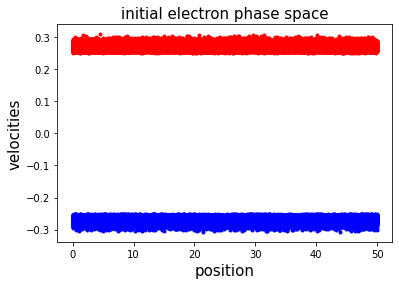

In [185]:
r_arr = np.array([np.random.uniform(0, total_length) for i in range(tot_particles)])
r_arr_i = np.copy(r_arr)
# i think scale is representing the temperature since at a lower scale/temp, the
# particles are more clumped up. As scale/temp increases, the particles move less as
# time goes on.
# loc is drift velocity
velocities = maxwell.rvs(size=tot_particles, loc=2*dx, scale=0.1*dx)
velocities[0:tot_particles//2] *= -1 # giving half a negative velocity (two stream)

v1 = velocities[0:tot_particles//2]
v2 = velocities[tot_particles//2:]

r1 = r_arr[0:tot_particles//2]
r2 = r_arr[tot_particles//2:]

plt.plot(r1, v1, 'b.')
plt.plot(r2, v2, 'r.')
plt.title('initial electron phase space', fontsize=15)
plt.ylabel('velocities', fontsize=15)
plt.xlabel("position", fontsize=15)
plt.show()

### Getting initial values

In [186]:
# calculating weights based on initial positions
x_left1, x_right1 = get_current_x(N, r1, dx)
weight_j1, weight_jp11 = get_current_weights(x_left1, x_right1, r1, dx)

x_left2, x_right2 = get_current_x(N, r2, dx)
weight_j2, weight_jp12 = get_current_weights(x_left1, x_right1, r2, dx)

In [187]:
# ne = get_densities(x_left, x_right, weight_j, weight_jp1) * norm_const
n1 = get_densities(x_left1, x_right1, weight_j1, weight_jp11) * norm_const
n2 = get_densities(x_left2, x_right2, weight_j2, weight_jp12) * norm_const
ne = n1 + n2
ni = np.copy(ne)

In [188]:
# ignoring divide by zero error
# https://stackoverflow.com/questions/29950557/ignore-divide-by-0-warning-in-numpy
with np.errstate(divide='ignore', invalid='ignore'):
    phi_x = get_phi_x(ne - ni, x).real # taking real because imag part is zero
field_at_nodes = get_node_fields(diff_arr, phi_x, dx)

In [189]:
w1_fld = get_weighted_fields(field_at_nodes, weight_j1, weight_jp11, x_left1, x_right1)
w2_fld = get_weighted_fields(field_at_nodes, weight_j2, weight_jp12, x_left2, x_right2)

In [190]:
# initial acceleration
#accel = get_accel(weighted_fields)
a1 = get_accel(w1_fld) #accel[0:tot_particles//2]
a2 = get_accel(w2_fld) #accel[tot_particles//2:]

[-0.36988916  0.86931896  0.37566381 ...  0.11340384  3.55129199
 -2.57196374]


KeyboardInterrupt: 

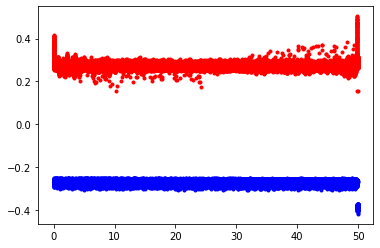

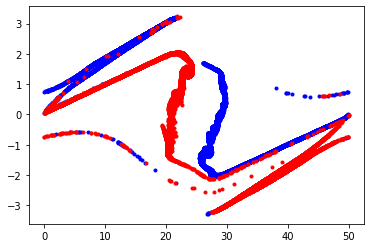

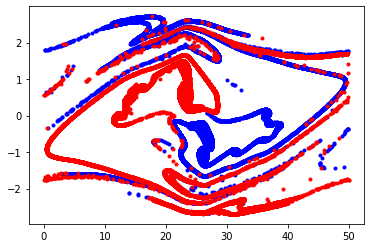

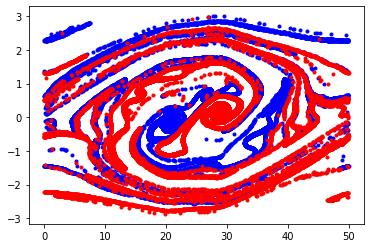

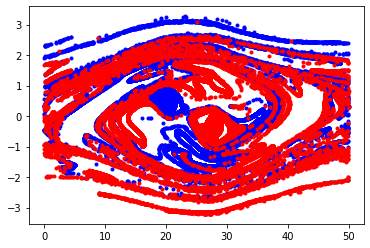

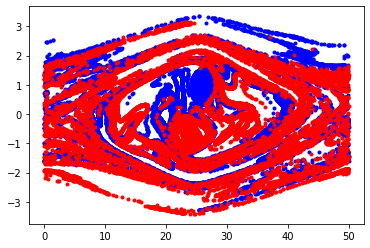

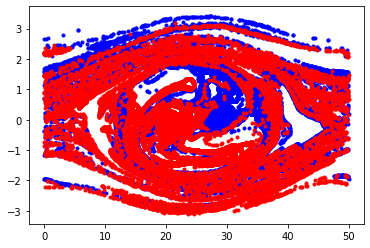

In [191]:
dt = 0.01
N_steps = 50000
sub_cycle = 1000
pot = np.zeros((N, N_steps//sub_cycle))
dens = np.zeros((N, N_steps//sub_cycle))
vel = np.zeros((N, N_steps//sub_cycle))
E_fld = np.zeros((N, N_steps//sub_cycle))

for i in range(N_steps):
    v1 += dt * a1 / 2
    v2 += dt * a2 / 2
    
    # new positions that will be used for weights
    r1 += dt * v1
    r2 += dt * v2
    # making sure they are between 0 and total_length
    r1 = r1 % total_length
    r2 = r2 % total_length
    
    ##### node calculations
    # calculating new weights
    x_left1, x_right1 = get_current_x(N, r1, dx)
    x_left2, x_right2 = get_current_x(N, r2, dx)
    weight_j1, weight_jp11 = get_current_weights(x_left1, x_right1, r1, dx)
    weight_j2, weight_jp12 = get_current_weights(x_left2, x_right2, r2, dx)
    # densities
    n1 = get_densities(x_left1, x_right1, weight_j1, weight_jp11) * norm_const
    n2 = get_densities(x_left2, x_right2, weight_j2, weight_jp12) * norm_const
    ne = n1 + n2
    
    with np.errstate(divide='ignore', invalid='ignore'):
        phi_x = get_phi_x(ne-ni, x).real
    field_at_nodes = get_node_fields(diff_arr, phi_x, dx)
    ##########
    
    w1_fld = get_weighted_fields(field_at_nodes, weight_j1, weight_jp11, x_left1, x_right1)
    w2_fld = get_weighted_fields(field_at_nodes, weight_j2, weight_jp12, x_left2, x_right2)
    
    if i%sub_cycle==0:
        pot[:, i//sub_cycle] = phi_x
        dens[:, i//sub_cycle] = ne
        E_fld[:, i//sub_cycle] = field_at_nodes
        with h5py.File(sim_fold+'/dt_{:n}.hdf5'.format(i//sub_cycle), 'w') as file:
            file.create_dataset('species1_pos', data=r1, chunks=True)
            file.create_dataset('species2_pos', data=r2, chunks=True)
            file.create_dataset('species1_vel', data=v1, chunks=True)
            file.create_dataset('species2_vel', data=v2, chunks=True)

    a1 = get_accel(w1_fld)
    a2 = get_accel(w2_fld)
    
    v1 += dt * a1 / 2
    v2 += dt * a2 / 2
    
    if i%(N_steps//10)==0:
        
        plt.figure()
        plt.plot(r1, v1, 'b.')
        plt.plot(r2, v2, 'r.')

file = h5py.File(sim_fold+'/ne.hdf5', 'w')
file.create_dataset('ne', data=dens, chunks=True)
file.close()
file = h5py.File(sim_fold+'/pot.hdf5', 'w')
file.create_dataset('pot', data=pot, chunks=True)
file.close()
file = h5py.File(sim_fold+'/E_fld.hdf5', 'w')
file.create_dataset('E_fld', data=E_fld, chunks=True)
file.close()

### Animating $v_0 \sim \pm 2 \Delta x \omega_p$

It has two phase space holes but I'd expect it to have more I think.

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fontsize = 15
# plt.rcParams['axes.grid'] = True
def animate(i):
    file_r = h5py.File('pic_data/two_stream_v0_2dx/dt_{}.hdf5'.format(i), 'r')
    pos1 = np.array(file_r.get('species1_pos'))
    pos2 = np.array(file_r.get('species2_pos'))
    vel1 = np.array(file_r.get('species1_vel'))
    vel2 = np.array(file_r.get('species2_vel'))
    file_r.close()
    ax.cla()
    ax.set_ylim(-4, 4)
    
    ax.scatter(pos1, vel1, s=0.01, label="negative vel")
    ax.scatter(pos2, vel2, s=0.01, label="positive vel")
    ax.set_ylabel("velocity", fontsize=fontsize)
    ax.set_xlabel("position", fontsize=fontsize)
    ax.set_title("Phase space w/ $v_0 \sim \pm 2 \Delta x \omega_p$", fontsize=fontsize)
#     ax.legend(loc="upper right")
    

ani = FuncAnimation(fig, animate, frames=30, interval=150)

plt.close()
writer = matplotlib.animation.writers['ffmpeg'](fps=30)
ani.save("dx2.mp4", writer=writer, dpi=800)
HTML(ani.to_html5_video())

### Animating $v_0 \sim \pm 10 \Delta x \omega_p$

Hmmm, it should have one phase space hole, but it still has two -- I'm not sure what's up with that. Also I forgot to make the figsize bigger and this animation takes quite a while to run, s

In [201]:
fig, ax = plt.subplots(1, 1)
fontsize = 15

def animate(i):
    file_r = h5py.File('pic_data/two_stream_v0_10dx/dt_{}.hdf5'.format(i), 'r')
    pos1 = np.array(file_r.get('species1_pos'))
    pos2 = np.array(file_r.get('species2_pos'))
    vel1 = np.array(file_r.get('species1_vel'))
    vel2 = np.array(file_r.get('species2_vel'))
    file_r.close()
    ax.cla()
    ax.set_ylim(-4, 4)
    ax.scatter(pos1, vel1, s=0.01, label="negative vel")
    ax.scatter(pos2, vel2, s=0.01, label="positive vel")
    ax.set_ylabel("velocity", fontsize=fontsize)
    ax.set_xlabel("position", fontsize=fontsize)
    ax.set_title("Phase space w/ $v_0 \sim \pm 10 \Delta x \omega_p$", fontsize=fontsize)
#     ax.legend(loc="upper right")
    

ani = FuncAnimation(fig, animate, frames=199, interval=50)

plt.close()
writer = matplotlib.animation.writers['ffmpeg'](fps=30)
ani.save("dx2.mp4", writer=writer, dpi=800)
HTML(ani.to_html5_video())

### Plotting $\phi(x, t)$

The potential seems to be consistently stronger in the grid cells closer to the center.

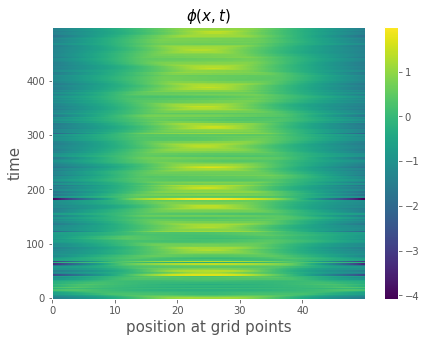

In [217]:
file_r = h5py.File('pic_data/two_stream_v0_10dx/pot.hdf5'.format(i), 'r')
pot = np.array(file_r.get('pot'))
file_r.close()

fontsize = 15
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_title("$\phi(x, t)$", fontsize=fontsize)
ax.set_xlabel("position at grid points", fontsize=fontsize)
ax.set_ylabel("time", fontsize=fontsize)
# ax=fig.add_subplot(111)
N_steps = 50000
sub_cycle = 250
xx, tt = np.meshgrid(x, np.arange(0, N_steps*dt, sub_cycle*dt))
plt.rcParams['axes.grid'] = False
im = ax.pcolormesh(xx, tt, pot.T, shading='auto')
plt.rcParams['axes.grid'] = False
fig.colorbar(im)
plt.show()

### Plotting $E(x, t)$

The electric field oscillates in the middle of the system.

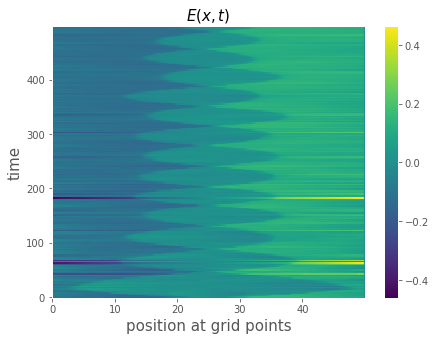

In [219]:
file_r = h5py.File('pic_data/two_stream_v0_10dx/E_fld.hdf5'.format(i), 'r')
E_fld = np.array(file_r.get('E_fld'))
file_r.close()

fontsize = 15
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_title("$E(x, t)$", fontsize=fontsize)
ax.set_xlabel("position at grid points", fontsize=fontsize)
ax.set_ylabel("time", fontsize=fontsize)
# ax=fig.add_subplot(111)
N_steps = 50000
sub_cycle = 250
xx, tt = np.meshgrid(x, np.arange(0, N_steps*dt, sub_cycle*dt))
plt.rcParams['axes.grid'] = False
im = ax.pcolormesh(xx, tt, E_fld.T, shading='auto')
plt.rcParams['axes.grid'] = False
fig.colorbar(im)
plt.show()

## Code Tests

### Testing solver for tridiagonal matrix equation

Tridagonal matrix equations are of the form

$$
\begin{pmatrix}
b_1 & c_1 & 0 & \dots & 0 & 0 \\
a_2 & b_2 & c_2 &  & & 0\\
0 & a_2 & b_3 & &  &  \vdots\\
\vdots  &   & &  \ddots & & 0\\
0 &  & & a_{n-1} & b_{n-1} & c_{n-1}\\
0 & 0 & \dots& 0 & a_n & b_n
\end{pmatrix}
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
\vdots \\
x_{n - 1} \\
x_n \\
\end{pmatrix}
=
\begin{pmatrix}
d_1 \\
d_2 \\
d_3 \\
\vdots \\
d_{n - 1} \\
d_n \\
\end{pmatrix}
$$

In [25]:
N = 100
center_diag = np.random.rand(1, N)[0]
right_diag = np.random.rand(1, N - 1)[0]
left_diag = np.random.rand(1, N - 1)[0]

rand_tridiag = np.diag(center_diag, 0) + np.diag(left_diag, -1) + np.diag(right_diag, 1)
d_arr = np.arange(0, N, 1)

We can test `solve_tri_matrix` by using `np.linalg.inv` to inverse the matrix and solve for $\vec x$ since `solve_tri_matrix` also solves for $\vec x$:

In [26]:
my_x = solve_tri_matrix(rand_tridiag, d_arr)
numpy_x = np.linalg.inv(rand_tridiag) @ d_arr
if np.isclose(my_x, numpy_x).all():
    print("yay")

yay


We can also check if we get back our original $\vec d$ using our computed $\vec x$ via $\vec d = A \vec x$, where $A$ is the tridiagonal matrix:

In [27]:
d_arr_check = rand_tridiag @ my_x
if np.isclose(d_arr, d_arr_check).all():
    print("yay")

yay


### Testing solver for "almost" tridiagonal matrix equations

"Almost" tridagonal matrix equations of the form

$$
\begin{pmatrix}
b_1 & c_1 & 0 & \dots & 0 & a_1 \\
a_2 & b_2 & c_2 &  & & 0\\
0 & a_2 & b_3 & &  &  \vdots\\
\vdots  &   & &  \ddots & & 0\\
0 &  & & a_{n-1} & b_{n-1} & c_{n-1}\\
c_n & 0 & \dots& 0 & a_n & b_n
\end{pmatrix}'
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
\vdots \\
x_{n - 1} \\
x_n \\
\end{pmatrix}'
=
\begin{pmatrix}
d_1 \\
d_2 \\
d_3 \\
\vdots \\
d_{n - 1} \\
d_n \\
\end{pmatrix}'
$$

where the first and last rows wrap around to other side and the primes indicate that it is different than the tridiagonal matrix equation.

In [29]:
# creating random "almost" tridiag matrix
N = 100
center_diag = np.random.rand(1, N)[0]
right_diag = np.random.rand(1, N - 1)[0]
left_diag = np.random.rand(1, N - 1)[0]

rand_almost_tridiag = np.diag(center_diag, 0) + np.diag(left_diag, -1) + np.diag(right_diag, 1)
rand_almost_tridiag[0][-1] = np.random.randint(1)
rand_almost_tridiag[-1][0] = np.random.randint(1)
d_arr = np.arange(0, N, 1)

We can test `solve_almost_tri` by using `np.linalg.inv` to inverse the matrix and solve for $\vec{x'}$ since `solve_almost_tri` also solves for $\vec{x'}$:

In [30]:
my_almost_x = solve_almost_tri(rand_almost_tridiag, d_arr)
numpy_almost_x = np.linalg.inv(rand_almost_tridiag) @ d_arr

if np.isclose(my_almost_x, numpy_almost_x).all():
    print("yay")

yay


We can also check if we get back our original $\vec{d'}$ using our computed $\vec{x'}$ via $\vec{d'} = A' \vec{x'}$, where $A'$ is the almost tridiagonal matrix:

In [31]:
d_arr_check = rand_almost_tridiag @ my_almost_x
if np.isclose(d_arr, d_arr_check).all():
    print("yay")

yay


### Making finite difference matrix

In [174]:
center_diag = np.full((1, N), -2)[0]
ones_diag = np.ones((1, N - 1))[0]
finite_diff_arr = np.diag(center_diag, 0) + np.diag(ones_diag, -1) + np.diag(ones_diag, 1)
finite_diff_arr[0][-1] = 1
finite_diff_arr[-1][:] = 1

[[-2.  1.  0. ...  0.  0.  1.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]


### Testing DFT Solver

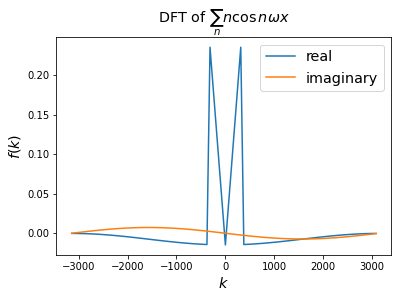

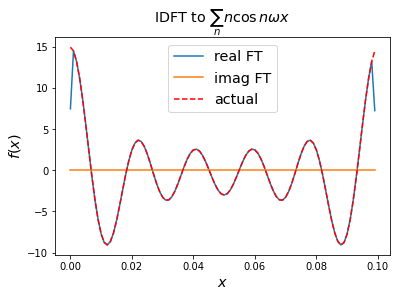

In [32]:
x = np.arange(0,0.1,0.001)
omg = 10*2*np.pi
func_test = np.cos(omg*x) + 2*np.cos(2*omg*x) + 3*np.cos(3*omg*x) + 4*np.cos(4*omg*x) + 5*np.cos(5*omg*x)

func_fft, k_vals = FFT_1D(func_test, x)
# plt.plot(x, ne)
fontsize = 'x-large'
plt.figure()
plt.title("DFT of $\sum_n{n \cos{n \omega x}}$", fontsize = 'x-large')
plt.plot(k_vals,func_fft.real, label="real")
plt.plot(k_vals,func_fft.imag, label="imaginary")
plt.xlabel("$k$", fontsize = 'x-large')
plt.ylabel("$f(k)$", fontsize = 'x-large')
plt.legend(fontsize = 'x-large')

unfft = IFFT_1D(func_fft, k_vals, x)
plt.figure()
plt.title("IDFT to $\sum_n{n \cos{n \omega x}}$", fontsize = 'x-large')
plt.plot(x,unfft.real, label="real FT")
plt.plot(x,unfft.imag, label="imag FT")
plt.plot(x,func_test, linestyle='--', c='r', label="actual")
plt.xlabel("$x$", fontsize = 'x-large')
plt.ylabel("$f(x)$", fontsize = 'x-large')
plt.legend(fontsize = 'x-large')
plt.show()

## Functions that tried their best

In [33]:
# def get_weighted_fields(particles_per_bin, x, r_arr, E_nodes):
#     N = len(weights)
#     dx = x[1] - x[0]
#     tot_particles = np.sum(particles_per_bin)
#     weighted_fields = np.zeros(tot_particles)
    
#     current_amt = 0
#     field_weights = np.zeros(N)
#     for j, n_particles in enumerate(particles_per_bin):
#         for i in range(n_particles):
#             field_weights[j] += ((x[j] + dx) - r_arr[i + current_amt]) / dx
#             field_weights[(j + 1) % N] += (r_arr[i + current_amt] - x[j]) / dx
#             weighted_fields[i + current_amt] = weights[j] * E_nodes[j] \
#                             + weights[(j + 1) % N] * E_nodes[(j + 1) % N]
#         current_amt += n_particles
    
#     return weighted_fields

In [34]:
# def get_weights(particles_per_bin, x, r_arr):
#     N = len(x) # number of bins
#     dx = x[1] - x[0]
#     current_amt = 0
#     dens_weights = np.zeros(N) # weights for calculating densities
#     for j, n_particles in enumerate(particles_per_bin):
#         for i in range(n_particles):
#             dens_weights[j] += ((x[j] + dx) - r_arr[i + current_amt]) / dx
#             dens_weights[(j + 1) % N] += (r_arr[i + current_amt] - x[j]) / dx
        
#         current_amt += n_particles
        
#     return dens_weights